<div style="
  text-align: center; 
  color: white; 
  background: linear-gradient(135deg, #2e8b57, #3cb371); 
  padding: 25px; 
  border-radius: 12px;
  box-shadow: 0 4px 10px rgba(0,0,0,0.2);
  max-width: 600px;
  margin: 30px auto;
">
  <h1 style="margin: 0; font-size: 2.2em;">Waste Management ML Model Training</h1>
  <p style="font-size: 18px; margin-top: 8px; opacity: 0.95;">
    Predicting recycling rates with preprocessing pipelines and advanced models
  </p>
</div>

# 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, SGDRegressor
from sklearn.feature_selection import SelectFromModel

# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MLflow for tracking
import mlflow
import mlflow.sklearn

# For model explanation
import shap

import warnings
warnings.filterwarnings('ignore')

# 2. Data Ingestion

In [3]:
df = pd.read_csv('../data/processed/Waste_Management_and_Recycling_india_cleaned.csv')
df.head()

,city/district,waste_type,waste_generated_(tons/day),recycling_rate_(%),population_density_(people/km²),municipal_efficiency_score_(1_10),disposal_method,cost_of_waste_management_(₹/ton),awareness_campaigns_count,landfill_name,"landfill_location_(lat,_long)",landfill_capacity_(tons),year
0,Mumbai,Plastic,6610,68,11191,9,Composting,3056,14,Mumbai Landfill,"22.4265, 77.4931",45575,1970
1,Mumbai,Organic,1181,56,11191,5,Composting,2778,12,Mumbai Landfill,"22.4265, 77.4931",45575,1970
2,Mumbai,E-Waste,8162,53,11191,8,Incineration,3390,13,Mumbai Landfill,"22.4265, 77.4931",45575,1970
3,Mumbai,Construction,8929,56,11191,5,Landfill,1498,14,Mumbai Landfill,"22.4265, 77.4931",45575,1970
4,Mumbai,Hazardous,5032,44,11191,7,Recycling,2221,16,Mumbai Landfill,"22.4265, 77.4931",45575,1970


In [4]:
# Check available columns
print("Available columns:", df.columns.tolist())

Available columns: ['city/district', 'waste_type', 'waste_generated_(tons/day)', 'recycling_rate_(%)', 'population_density_(people/km²)', 'municipal_efficiency_score_(1_10)', 'disposal_method', 'cost_of_waste_management_(₹/ton)', 'awareness_campaigns_count', 'landfill_name', 'landfill_location_(lat,_long)', 'landfill_capacity_(tons)', 'year']


# 2. Feature Engneering

- We know 4 cols are highly correlated ['landfill_capacity', 'landfill_location', 'landfill_name', 'population_density'].
- so, i will begin with removing some of them.
- Note, not all algorithms required to handle correlation externally. for eg:- Tree_based and Neural Network (sometimes)

In [5]:
# we will drop highly correlated cols and create some new features
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['recycling_rate_(%)'])

X = add_constant(numeric_cols)
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif


,Features,VIF
0,waste_generated_(tons/day),1.003641
1,population_density_(people/km²),1.075553
2,municipal_efficiency_score_(1_10),1.016138
3,cost_of_waste_management_(₹/ton),1.008551
4,awareness_campaigns_count,1.008001
5,landfill_capacity_(tons),1.072210
6,year,47.815339


### Insights
- No cols in numeric in are highly correlated i.e > 5, except year
- we will drop year for 2 main reasons, 1. it's constant(only one value throught out the records) 2. no usefull information.

### 2.1 We will also drop the useless categorical cols which are in high correlations.

In [6]:
# Dropping year col
df1 = df.copy()
df1.drop(columns=['year', 'landfill_name', 'landfill_location_(lat,_long)'], inplace=True, errors='ignore')

### 2.2 Creating New Features

In [7]:
# Feature 1: How much over landfill capacity can actually utilize land for monthly waste, percentage
df1['landfill_monthly_limit_(%)'] =  ((df1['landfill_capacity_(tons)'] / (df1['waste_generated_(tons/day)'] * 30)) * 100).round()

In [8]:
# Feature 2: Awareness campaign effectiveness - potential impact of campaigns on recycling
df1['campaign_density'] = (df1['awareness_campaigns_count'] /   df1['population_density_(people/km²)']).round(4) * 1000  

**Created 2 New Features :**
- landfill_monthly_limit_(%) : How much over landfill capacity can actually utilize land for monthly waste, percentage.
- campaign_density : Awareness campaign effectiveness - potential impact of campaigns on recycling

# 3. Defining Features & Target + Train_Test_Split

In [9]:
X = df1.drop(columns=['recycling_rate_(%)'])
y = df1['recycling_rate_(%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# 4. Preprocessing Pipelines

In [10]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_cols = X.select_dtypes(include=['object']).columns.to_list()

numeric_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_encoder = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_scaler, numeric_cols),
    ('cat', categorical_encoder, categorical_cols)
])

# 5. Cross_Val_Check

In [11]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=150, verbose=0, random_state=7),
    "xgboost": xgb.XGBRegressor(n_estimators=150, random_state=7, verbosity=0),
    "CatBoostRegressor": CatBoostRegressor(n_estimators=150, verbose=0, random_state=7),
    "lightgbm": lgb.LGBMRegressor(n_estimators=150, random_state=7)
}

results = []
for name, model in models.items():
    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)])
    
    rmse = cross_val_score(clf, X_train, y_train, cv=6, scoring='neg_root_mean_squared_error', n_jobs=-1)
    r2 = cross_val_score(clf, X_train, y_train, cv=6, scoring='r2', n_jobs=-1)
    
    results.append({
        "Model": name,
        "RMSE": -rmse.mean().round(2),
        "R2": r2.mean().round(2)
    })
    
    print(f"{name}: RMSE = {-rmse.mean():.4f}, R² = {r2.mean():.4f}")

ranks = pd.DataFrame(results)
ranks.sort_values(by='RMSE', ascending=True)

LinearRegression: RMSE = 16.9278, R² = -0.1070
Lasso: RMSE = 16.1739, R² = -0.0093
RandomForestRegressor: RMSE = 16.5978, R² = -0.0643
xgboost: RMSE = 18.3978, R² = -0.3083
CatBoostRegressor: RMSE = 17.3524, R² = -0.1639
lightgbm: RMSE = 17.8695, R² = -0.2362


,Model,RMSE,R2
1,Lasso,16.17,-0.01
2,RandomForestRegressor,16.60,-0.06
0,LinearRegression,16.93,-0.11
4,CatBoostRegressor,17.35,-0.16
5,lightgbm,17.87,-0.24
3,xgboost,18.40,-0.31


> *As we can see our R2 score is worse than mean*
- we will use another dataset_with_additional_features with strong predective features, previous lacked predictive power.

# 6. Model 2.0

## Data Ingestion
- ingestion data with strong additional collected features

In [12]:
df_extra = pd.read_csv("..\data\processed\Waste_Management_with_Extra_Features.csv")
df_extra.drop(columns=['year', 'landfill_name', 'landfill_location_(lat,_long)'], inplace=True, errors='ignore')

## 6.1 Defining Features & Target + Train_Test_Split

In [13]:
X_new = df_extra.drop(columns=['recycling_rate_(%)'])
y_new = df_extra['recycling_rate_(%)']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=7)

## 6.2 Preprocessing Pipelines

In [14]:
numeric_cols = X_new.select_dtypes(include=['int64', 'float64']).columns.to_list()
categorical_cols = X_new.select_dtypes(include=['object']).columns.to_list()

numeric_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_encoder = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_scaler, numeric_cols),
    ('cat', categorical_encoder, categorical_cols)
])

## 6.3 Cross_val_check
- Quick screen using cross_val_score of various algorithm to find overall best performing.

In [15]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=150, verbose=0, random_state=7),
    "xgboost": xgb.XGBRegressor(n_estimators=150, random_state=7, verbosity=0),
    "CatBoostRegressor": CatBoostRegressor(n_estimators=150, verbose=0, random_state=7),
    "lightgbm": lgb.LGBMRegressor(n_estimators=150, random_state=7)
}

results = []
for name, model in models.items():
    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)])
    
    rmse = cross_val_score(clf, X_train, y_train, cv=6, scoring='neg_root_mean_squared_error', n_jobs=-1)
    r2 = cross_val_score(clf, X_train, y_train, cv=6, scoring='r2', n_jobs=-1)
    
    results.append({
        "Model": name,
        "RMSE": -rmse.mean().round(2),
        "R2": r2.mean().round(2)
    })
    
    print(f"{name}: RMSE = {-rmse.mean():.4f}, R² = {r2.mean():.4f}")

ranks = pd.DataFrame(results)
ranks.sort_values(by='RMSE', ascending=True)

LinearRegression: RMSE = 1.7347, R² = 0.9884
Lasso: RMSE = 1.9505, R² = 0.9853
RandomForestRegressor: RMSE = 1.8504, R² = 0.9868
xgboost: RMSE = 1.9675, R² = 0.9850
CatBoostRegressor: RMSE = 2.0167, R² = 0.9842
lightgbm: RMSE = 1.8545, R² = 0.9867


,Model,RMSE,R2
0,LinearRegression,1.73,0.99
2,RandomForestRegressor,1.85,0.99
5,lightgbm,1.85,0.99
1,Lasso,1.95,0.99
3,xgboost,1.97,0.99
4,CatBoostRegressor,2.02,0.98


# 7. Hyper-Parameter Tuning

In [24]:
ridge_reg = Ridge(random_state=7)

from sklearn.feature_selection import SelectKBest, f_regression

pipe_tune = Pipeline([
    ("preprocessor", preprocessor),
    ("select_features", SelectKBest(score_func=f_regression, k=4)),  # Select exactly top 4 features
    ("model", ridge_reg)
])


params = {
    "model__alpha": np.logspace(-4, 4, 20), 
    "model__fit_intercept": [True],  
    "model__solver": ['auto', 'sparse_cg', 'lsqr']
}

cv = KFold(n_splits=6, random_state=7, shuffle=True)
grid = RandomizedSearchCV(
    pipe_tune, 
    param_distributions=params, 
    n_iter=20, 
    cv=cv, 
    scoring="neg_root_mean_squared_error", 
    n_jobs=-1, 
    random_state=7,
    error_score='raise'
)

In [25]:
try:
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}, Best RMSE: {-grid.best_score_:.4f}")
except Exception as e:
    print("GridSearch error:", e)
    print("X NaN:", X_train.isna().any().any(), "| y NaN:", pd.isna(y_train).any())

Best params: {'model__solver': 'lsqr', 'model__fit_intercept': True, 'model__alpha': np.float64(1.623776739188721)}, Best RMSE: 1.6765


## 7.1  Grid Model Train and Evaluate

In [26]:
model = grid.best_estimator_
for name, (X, y) in {"Train": (X_train, y_train), "Test": (X_test, y_test)}.items():
    pred = model.predict(X)
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y, pred)):.4f}, R²: {r2_score(y, pred):.4f}")

print("Generalization Gap (RMSE):",
      np.sqrt(mean_squared_error(y_test, model.predict(X_test))) -
      np.sqrt(mean_squared_error(y_train, model.predict(X_train))))


Train RMSE: 1.6608, R²: 0.9894
Test RMSE: 1.4717, R²: 0.9915
Generalization Gap (RMSE): -0.18900869498826167


# 8. Feature Evaluation

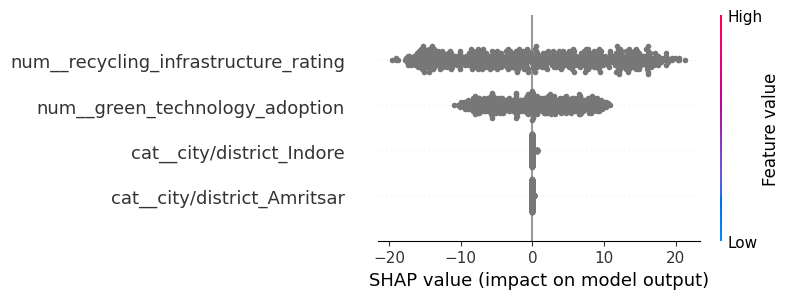


Selected Top 4 Features:
1. num__green_technology_adoption
2. num__recycling_infrastructure_rating
3. cat__city/district_Amritsar
4. cat__city/district_Indore

Feature Selection Scores (Top 10):
                                   Feature         Score
10    num__recycling_infrastructure_rating  42017.114657
9           num__green_technology_adoption  20751.862000
23               cat__city/district_Indore      7.001706
14             cat__city/district_Amritsar      4.568116
0          num__waste_generated_(tons/day)      0.000000
2   num__municipal_efficiency_score_(1_10)      0.000000
5            num__landfill_capacity_(tons)      0.000000
4           num__awareness_campaigns_count      0.000000
3    num__cost_of_waste_management_(₹/ton)      0.000000
7          num__industrial_symbiosis_index      0.000000


In [27]:
# Get the feature selector and the reduced feature names
pre = model.named_steps['preprocessor']
selector = model.named_steps['select_features']
ridge_model = model.named_steps['model']

# Transform data through preprocessing
X_train_pre = pre.transform(X_train)
feature_names_all = pre.get_feature_names_out()

# Apply feature selection to get selected features
X_train_sel = selector.transform(X_train_pre)
selected_indices = selector.get_support()
selected_feature_names = feature_names_all[selected_indices]

# SHAP for linear model with selected features
explainer = shap.Explainer(ridge_model, X_train_sel, feature_names=selected_feature_names)
shap_values = explainer(X_train_sel)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_sel, feature_names=selected_feature_names)

# Display selected features for reference
print("\nSelected Top 4 Features:")
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {feature}")

# Display feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names_all,
    'Score': np.zeros(len(feature_names_all))
})
feature_scores.loc[selected_indices, 'Score'] = selector.scores_[selected_indices]
print("\nFeature Selection Scores (Top 10):")
print(feature_scores.sort_values('Score', ascending=False).head(10))

# 9. Exporting The Model

In [31]:
import joblib

joblib.dump(model, "../models/waste_mgmt.joblib")

['../models/waste_mgmt.joblib']

In [ ]:
import joblib
import pandas as pd

pipeline = joblib.load("../models/waste_mgmt.joblib")

# Use X_new to create a single test sample with all required columns
sample = X_new.iloc[[13]].copy()  # Copy one row from our dataset

# Make prediction
prediction = pipeline.predict(sample)
print(f"Predicted recycling rate: {prediction[0]:.2f}%")
print(f"Actual recycling rate: {y_new.iloc[13]:.2f}%")

# Print features used by model
print("\nAll features in dataset:", X_new.shape[1])
print("Features selected by model:", len(pipeline.named_steps['select_features'].get_support(indices=True)))

Predicted recycling rate: 76.52%
Actual recycling rate: 77.00%

All features in dataset: 14
Features selected by model: 4


In [44]:
sample

,city/district,waste_type,waste_generated_(tons/day),population_density_(people/km²),municipal_efficiency_score_(1_10),disposal_method,cost_of_waste_management_(₹/ton),awareness_campaigns_count,landfill_capacity_(tons),waste_reduction_initiatives,industrial_symbiosis_index,community_participation_score,green_technology_adoption,recycling_infrastructure_rating
13,Mumbai,Construction,3514,11191,9,Incineration,3520,0,45575,1.967127,8.714841,1.901256,7.560427,77.3555


# 10. Focused Model with Only Important Features

Now that we've identified the most important features, we can train a more focused model using just those features. This can improve:
- Model interpretability
- Training speed
- Potentially reduce overfitting
- Make deployment simpler

In [49]:
# Define specific features to keep
specific_features = [
    'city/district',
    'recycling_infrastructure_rating',
    'green_technology_adoption'
]

# Create focused datasets with specified features
X_train_focused = X_train[specific_features].copy()
X_test_focused = X_test[specific_features].copy()

# Create focused preprocessing pipeline
focused_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['recycling_infrastructure_rating', 'green_technology_adoption']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['city/district'])
])

# Create pipeline with SelectKBest = 4
focused_pipeline = Pipeline([
    ("preprocessor", focused_preprocessor),
    ("select_features", SelectKBest(score_func=f_regression, k=4)),
    ("model", Ridge(alpha=grid.best_params_['model__alpha'], random_state=7))
])

# Train focused model
focused_pipeline.fit(X_train_focused, y_train)

# Evaluate model
for name, (X, y) in {"Train": (X_train_focused, y_train), "Test": (X_test_focused, y_test)}.items():
    pred = focused_pipeline.predict(X)
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y, pred)):.4f}, R²: {r2_score(y, pred):.4f}")

# Save focused model
joblib.dump(focused_pipeline, "../models/waste_mgmt_focused.joblib")

Train RMSE: 1.6608, R²: 0.9894
Test RMSE: 1.4717, R²: 0.9915


['../models/waste_mgmt_focused.joblib']

In [50]:
# Test focused model with a sample
focused_model = joblib.load("../models/waste_mgmt_focused.joblib")
sample_focused = X_new.loc[[13], specific_features].copy()
prediction = focused_model.predict(sample_focused)
print(f"Focused model prediction: {prediction[0]:.2f}%")
print(f"Actual recycling rate: {y_new.iloc[13]:.2f}%")

Focused model prediction: 76.52%
Actual recycling rate: 77.00%
